### Домашнее задание №1 Кошкиной Ксении

In [291]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
import sklearn

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from sklearn.metrics import r2_score
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import neighbors
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_validate, train_test_split
from sklearn import tree
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.svm import LinearSVR
from langdetect import detect, DetectorFactory
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.metrics import *

In [5]:
df = pd.read_csv("Shoes_Data.csv")

In [6]:
df['rating']=df['rating'].apply(lambda x: str(x).replace(' out of 5 stars','') if ' out of 5 stars' in str(x) else str(x))
df['price']=df['price'].apply(lambda x: str(x).replace('₹','') if '₹' in str(x) else str(x))
df['total_reviews']=df['total_reviews'].apply(lambda x: str(x).replace(' ratings','') if ' ratings' in str(x) else str(x))
df['total_reviews']=df['total_reviews'].apply(lambda x: str(x).replace(' rating','') if ' rating' in str(x) else str(x))
df['rating']=df['rating'].astype(float)
df['price']=df['price'].astype(float)
df['total_reviews']=df['total_reviews'].astype(int)

Удалим дубликаты.

In [7]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

Здесь будут графики анализа, которые не требуются для дальнейшнего построения моделей, так как в чате было сказано использовать для построения только некоторые колонки, а не учитывать все.

Посмотрим, как меняется цена в зависимости от пола.

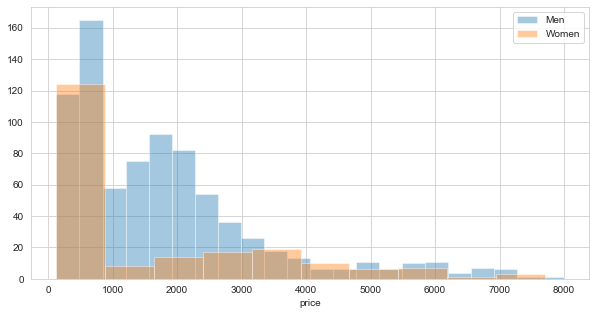

In [8]:
plt.figure(figsize=(10, 5))
sns.distplot(df[df["Shoe Type"]=="Men"].price,kde=False,rug=False)
sns.distplot(df[df["Shoe Type"]=="Women"].price,kde=False,rug=False)

plt.legend(labels=['Men', 'Women'])
plt.show()

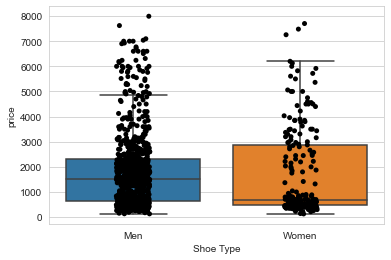

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='Shoe Type', y='price', data=df, showfliers=False, ax=ax)
sns.stripplot(x='Shoe Type', y='price', data=df, jitter=True, color='black', ax=ax)

plt.show()

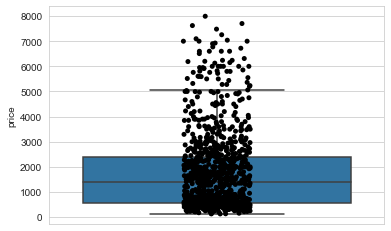

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(y='price', data=df, showfliers=False, ax=ax)
sns.stripplot(y='price', data=df, jitter=True, color='black', ax=ax)

plt.show()

На графиках выше можно увидеть достаточное количество выбросов, что может помешать хорошему анализу.

In [11]:
cost_prediction = df[['price','product_description']]

In [12]:
length_of_description = []
for item in cost_prediction.product_description:
    length_of_description.append(len(item.split()))

cost_prediction['length_of_description'] = length_of_description

In [13]:
cost_prediction.product_description[0]

'Elevate your style with this classy pair of Running Shoe from the house of CLYMB brand. Featuring a contemporary refined design with exceptional comfort this pair is perfect to give your quintessential dressing an upgrade.'

In [14]:
cost_prediction

,price,product_description,length_of_description
0,279.0,Elevate your style with this classy pair of Ru...,35
1,479.0,The product will be an excellent pick for you....,14
2,430.0,Flaunt with these stylish and unique red casua...,70
3,499.0,Robbie Jones Shoes Are Designed To Keeping In ...,100
4,499.0,Sparx is a spectacular range of footwear from ...,171
...,...,...,...
1010,7256.0,The Nike react vision is a STORY of surreal co...,39
1011,5822.0,The B.O.G limitless is Puma's key style for th...,141
1012,5362.0,Lead the pack in New Balance’s Echolucent snea...,51
1013,7480.0,Nike మహిళల రన్నింగ్ షూ ఫీల్స్ మరియు రూపం మృదువ...,222


In [15]:
cost_prediction.describe()

,price,length_of_description
count,1015.000000,1015.000000
mean,1789.546788,71.209852
std,1564.919370,100.216572
min,127.000000,0.000000
25%,569.000000,32.000000
50%,1399.000000,45.000000
75%,2403.500000,84.000000
max,7992.000000,1666.000000


Удалим строчки, где длина описания равна 0.

In [16]:
cost_prediction = cost_prediction.drop(cost_prediction[cost_prediction.length_of_description == 0].index)

Но надо также посмотреть, как выглядят строчки, равные 1, так как длина такого описания подозрительна.

In [17]:
cost_prediction[cost_prediction.length_of_description == 1]

,price,product_description,length_of_description
502,2119.0,Aaron.,1
780,7039.0,-,1
781,5949.0,-,1


Такие строчки бесполезны, поэтому их нужно удалить.

In [18]:
cost_prediction = cost_prediction.drop(cost_prediction[cost_prediction.length_of_description == 1].index)

In [19]:
cost_prediction.describe()

,price,length_of_description
count,1011.000000,1011.000000
mean,1779.704243,71.488625
std,1553.708060,100.316482
min,127.000000,2.000000
25%,569.000000,32.000000
50%,1390.000000,46.000000
75%,2400.500000,84.000000
max,7992.000000,1666.000000


Можно также заметить, что некоторые описания не на английском языке.

In [20]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0
languages_of_description = []
for item in cost_prediction.product_description:
    value = detect(item)
    languages_of_description.append(value)


cost_prediction['languages_of_description'] = languages_of_description



In [21]:
cost_prediction

,price,product_description,length_of_description,languages_of_description
0,279.0,Elevate your style with this classy pair of Ru...,35,en
1,479.0,The product will be an excellent pick for you....,14,en
2,430.0,Flaunt with these stylish and unique red casua...,70,en
3,499.0,Robbie Jones Shoes Are Designed To Keeping In ...,100,en
4,499.0,Sparx is a spectacular range of footwear from ...,171,en
...,...,...,...,...
1010,7256.0,The Nike react vision is a STORY of surreal co...,39,en
1011,5822.0,The B.O.G limitless is Puma's key style for th...,141,en
1012,5362.0,Lead the pack in New Balance’s Echolucent snea...,51,en
1013,7480.0,Nike మహిళల రన్నింగ్ షూ ఫీల్స్ మరియు రూపం మృదువ...,222,te


In [22]:
cost_prediction['languages_of_description'].unique()

array(['en', 'tl', 'fr', 'te', 'de', 'ml', 'ta', 'no', 'kn', 'af'],
      dtype=object)

Выведем для наглядности все элементы не на английском языке.

In [23]:
for item in cost_prediction[cost_prediction.languages_of_description != 'en'].product_description:
    print(item + '\n')

AADI SHOES

Closure : Lace up

Red Chief మీ ముందుకు తీసుకువచ్చిన ఈ లెదర్ పురుషుల స్లిప్పర్లలో సౌకర్యవంతంగా ఉండండి. పాడింగ్ యొక్క డబుల్ లేయర్ తో పూర్తి మెత్తటి ఎగువ మరియు ఫుట్-బెడ్ మీ సాధారణ వస్త్రధారణకు ఈ స్లిప్పర్లను అంతిమ ఎంపికగా మార్చడానికి తీవ్రమైన కుషనింగ్ మరియు సౌకర్యాన్ని అందిస్తుంది.______Stay comfortable in these leather men's Slippers brought to you by Red Chief. Fully padded upper and foot-bed with double layer of padding provides extreme cushioning and comfort to make these Slippers the ultimate choice for your casual attire.______Red Chief மூலம் உங்களிடம் கொண்டு வரும் இந்த தோல் ஆண்கள் செருப்புகளில் வசதியாக இருங்கள். பேடிங் இரட்டை அடுக்கு பேடிங் கொண்ட முழுமையாக பேட் செய்யப்பட்ட மேல் மற்றும் கால் படுக்கை இந்த ஸ்லிப்பர்களை உங்கள் கேஷுவல் உடைகளுக்கு இறுதி தேர்வாக மாற்ற உதவுகிறது.______Red Chief-ൽ നിന്നുള്ള ഈ ലെതർ പുരുഷന്മാരുടെ സ്ലിപ്പറുകൾ നിങ്ങൾക്കൊപ്പം സുഖമായിരിക്കൂ. ഇരട്ട പാളികളോടു കൂടിയ പൂർണ്ണമായും പാഡ് ചെയ്ത മുകൾ ഭാഗവും ഫൂട്ട്-ബെഡും ഈ സ്ലിപ്പറുകൾ നിങ്ങളുടെ കാഷ്വൽ വസ്ത്രത്ത

Вполне очевидно, что почти в каждом примере содержится или вообще не английский язык, или в одном примере смешано несколько языков, или детектор неправильно определил язык, поскольку в примере содержатся ненарицательные имена, использующиеся редко.

In [24]:
cost_prediction = cost_prediction[cost_prediction.languages_of_description == 'en']

In [25]:
cost_prediction

,price,product_description,length_of_description,languages_of_description
0,279.0,Elevate your style with this classy pair of Ru...,35,en
1,479.0,The product will be an excellent pick for you....,14,en
2,430.0,Flaunt with these stylish and unique red casua...,70,en
3,499.0,Robbie Jones Shoes Are Designed To Keeping In ...,100,en
4,499.0,Sparx is a spectacular range of footwear from ...,171,en
...,...,...,...,...
1009,7702.0,Converse is Change. We started on the court an...,95,en
1010,7256.0,The Nike react vision is a STORY of surreal co...,39,en
1011,5822.0,The B.O.G limitless is Puma's key style for th...,141,en
1012,5362.0,Lead the pack in New Balance’s Echolucent snea...,51,en


Теперь проанализируем непосредственно те данные, на которых будем обучать модель. Также сделаем препроцессинг. Приведем все к нижнему регистру, цена в числовой формат уже была переведена изначально. Также токенизируем и лемматизируем слова, уберем знаки пунктуации и стопслова.

In [290]:
lemmatizer = WordNetLemmatizer()

In [28]:
list_stopwords = set(stopwords.words('english'))
cost_prediction['clean_description'] = cost_prediction['product_description'].str.lower()
cost_prediction['clean_description'] = cost_prediction['clean_description'].apply(word_tokenize)
cost_prediction['clean_description'] = cost_prediction['clean_description'].apply(lambda x: [word for word in x if word not in list_stopwords])
cost_prediction['clean_description'] = cost_prediction['clean_description'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
cost_prediction['clean_description'] = cost_prediction['clean_description'].apply(lambda x: [word.translate(str.maketrans('', '', string.punctuation)) for word in x])
cost_prediction['clean_description'] = cost_prediction['clean_description'].apply(lambda x: [word for word in x if len(word) > 1])
cost_prediction['clean_description'] = cost_prediction['clean_description'].apply(lambda x: [re.sub(r'[^\w\s]+|[\d]+', r'', word).strip() for word in x])

После этого можно проанализировать цену, от которой мы будем отталкиваться при просмотре самых часто используемых слов. Графики приведены ниже.

In [29]:
cost_prediction.price.describe()

count     985.000000
mean     1732.771563
std      1509.365698
min       127.000000
25%       560.000000
50%      1330.000000
75%      2332.000000
max      7992.000000
Name: price, dtype: float64

In [30]:
for i in range(0, 100, 10):
    var = cost_prediction["price"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 127.0
10 percentile value is 399.0
20 percentile value is 499.0
30 percentile value is 629.0
40 percentile value is 829.0
50 percentile value is 1330.0
60 percentile value is 1736.0
70 percentile value is 2115.0
80 percentile value is 2699.0
90 percentile value is 3846.0
100 percentile value is  7992.0


In [31]:
cost_prediction_2=pd.DataFrame(cost_prediction['clean_description'].explode())

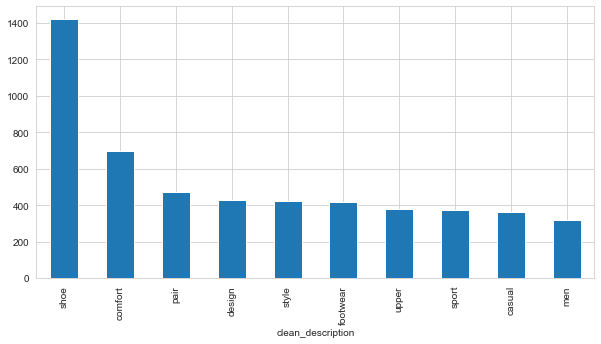

In [32]:
pd.set_option('display.max_rows',50)
cost_prediction_2.groupby('clean_description')['clean_description'].count().sort_values(ascending=False).head(10).plot.bar(figsize=(10,5))

Здесь мы посмотрели самые популярные слова независимо от цены, но интересно узнать какие слова содержатся в описании в зависимости от ценовой категории.

Распределим данные на два датафрейма, отталкиваясь от цены: в один - цена меньше 639, так как первые тридцать процентов меньше данной цены; во втоорой - цена больше 2157, по этим же причинам.

In [33]:
lowest = cost_prediction.loc[cost_prediction['price'] < 639]

In [34]:
lowest_2 = pd.DataFrame(lowest['clean_description'].explode())

In [35]:
highest = cost_prediction.loc[cost_prediction['price'] > 2157]

In [36]:
highest_2 = pd.DataFrame(highest['clean_description'].explode())

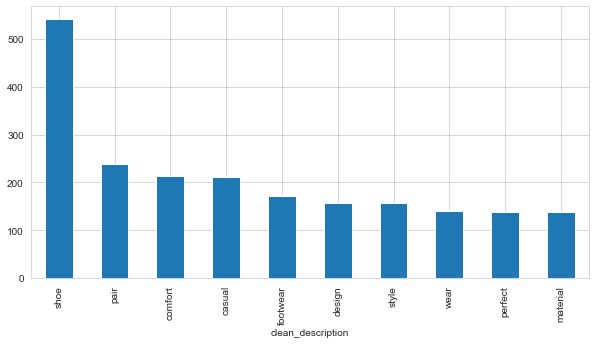

In [37]:
pd.set_option('display.max_rows',50)
lowest_2.groupby('clean_description')['clean_description'].count().sort_values(ascending=False).head(10).plot.bar(figsize=(10,5))

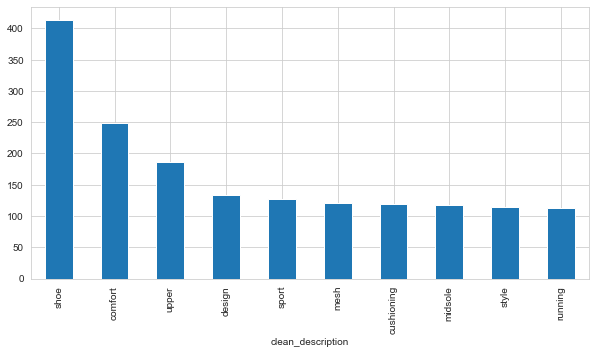

In [38]:
pd.set_option('display.max_rows',50)
highest_2.groupby('clean_description')['clean_description'].count().sort_values(ascending=False).head(10).plot.bar(figsize=(10,5))

На самом деле зависимости как таковой нет, кроме четвертого по популярности слова в каждом графике - в нижнем ценовом пороге это casual, в то время как более высоком это design.

In [39]:
cost_prediction['clean_description'] = cost_prediction['clean_description'].apply(lambda x: ' '.join(x))

In [40]:
cost_prediction.describe().round(3)

,price,length_of_description
count,985.000,985.000
mean,1732.772,65.277
std,1509.366,60.708
min,127.000,3.000
25%,560.000,32.000
50%,1330.000,45.000
75%,2332.000,83.000
max,7992.000,472.000


In [41]:
cost_prediction

,price,product_description,length_of_description,languages_of_description,clean_description
0,279.0,Elevate your style with this classy pair of Ru...,35,en,elevate style classy pair running shoe house c...
1,479.0,The product will be an excellent pick for you....,14,en,product excellent pick ensures easy maintenance
2,430.0,Flaunt with these stylish and unique red casua...,70,en,flaunt stylish unique red casual shoe per late...
3,499.0,Robbie Jones Shoes Are Designed To Keeping In ...,100,en,robbie jones shoe designed keeping mind durabi...
4,499.0,Sparx is a spectacular range of footwear from ...,171,en,sparx spectacular range footwear house relaxo ...
...,...,...,...,...,...
1009,7702.0,Converse is Change. We started on the court an...,95,en,converse change started court got adopted stre...
1010,7256.0,The Nike react vision is a STORY of surreal co...,39,en,nike react vision story surreal comfort layere...
1011,5822.0,The B.O.G limitless is Puma's key style for th...,141,en,bog limitless puma key style new season inspir...
1012,5362.0,Lead the pack in New Balance’s Echolucent snea...,51,en,lead pack new balance echolucent sneaker sneak...


Для начала рассмотрим модели с Count Vectorizer.

In [62]:
cv = CountVectorizer(max_features=1000)
X = cv.fit_transform(cost_prediction.clean_description)
y = cost_prediction.price.values

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

In [64]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [65]:
lin_reg = LinearRegression()

param_grid = {'fit_intercept':[True, False],
              'normalize':[True, False],
              'positive':[True, False]}

grid_cv_lin = GridSearchCV(lin_reg, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_cv_lin.fit(X_train.todense(), y_train)

print('Best parameters: ', grid_cv_lin.best_params_)
print('Best score: ', grid_cv_lin.best_score_)

preds = grid_cv_lin.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))

Best parameters:  {'fit_intercept': True, 'normalize': False, 'positive': True}
Best score:  -932.8224191589117
MAE:  945.901841742698
R2:  0.052005641516390755


In [66]:
ridge = Ridge()

ridge_alphas = np.linspace(0, 10, 21)

param_grid = {'alpha': ridge_alphas,
              'fit_intercept': [True, False],
              'normalize': [True, False]}

grid_cv_ridge = GridSearchCV(ridge, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_cv_ridge.fit(X_train.todense(), y_train)

print('Best parameters: ', grid_cv_ridge.best_params_)
print('Best score: ', grid_cv_ridge.best_score_)

preds = grid_cv_ridge.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))

Best parameters:  {'alpha': 1.0, 'fit_intercept': True, 'normalize': True}
Best score:  -797.5020975698461
MAE:  776.3406025656644
R2:  0.4115511752470845


In [67]:
lasso = Lasso()

lasso_alphas = np.linspace(0, 10, 21)

param_grid = {'alpha': lasso_alphas,
              'fit_intercept': [True, False],
              'normalize': [True, False]}

grid_cv_lasso = GridSearchCV(lasso, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_cv_lasso.fit(X_train.todense(), y_train)

print('Best parameters: ', grid_cv_lasso.best_params_)
print('Best score: ', grid_cv_lasso.best_score_)

preds = grid_cv_lasso.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))

Best parameters:  {'alpha': 6.5, 'fit_intercept': True, 'normalize': False}
Best score:  -818.3838621454445
MAE:  812.1550758508166
R2:  0.33603726074619034


In [68]:
dtm = tree.DecisionTreeRegressor()

param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [1, 1.5, 2, 5],
              "max_depth": [8, 16, 24, 32, 40],
              "min_samples_leaf": [1, 2],
              "max_leaf_nodes": [180, 200, 220, 240],
              }

grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=cv, scoring='neg_mean_absolute_error')

grid_cv_dtm.fit(X_train, y_train)

print('Best score: ', grid_cv_dtm.best_score_)
print('Best params: ', grid_cv_dtm.best_params_)

preds = grid_cv_dtm.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))

Best score:  -760.1468303752841
Best params:  {'criterion': 'mse', 'max_depth': 40, 'max_leaf_nodes': 200, 'min_samples_leaf': 1, 'min_samples_split': 5}
MAE:  799.5801959196774
R2:  0.17193769429127004


In [69]:
bay_ridge = linear_model.BayesianRidge()

param_grid = {'alpha_1':np.linspace(0, 10, 5),
              'alpha_2':np.linspace(0, 10, 5)
              }

grid_cv_bay = GridSearchCV(bay_ridge, param_grid, cv=cv, scoring='neg_mean_absolute_error')

grid_cv_bay.fit(X_train.todense(), y_train)

print('Best score: ', grid_cv_bay.best_score_)
print('Best params: ', grid_cv_bay.best_params_)

preds = grid_cv_bay.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))

Best score:  -794.9248140370362
Best params:  {'alpha_1': 0.0, 'alpha_2': 10.0}
MAE:  773.4552274659777
R2:  0.4158170451716864


Обучим на  TFIDF.

In [70]:
tv = TfidfVectorizer(max_features=1000)
X = tv.fit_transform(cost_prediction.clean_description)
y = cost_prediction.price.values

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [72]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lin_reg = LinearRegression()

param_grid = {'fit_intercept':[True, False],
              'normalize':[True, False],
              'positive':[True, False]}

grid_cv_lin = GridSearchCV(lin_reg, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_cv_lin.fit(X_train.todense(), y_train)

print('Best parameters: ', grid_cv_lin.best_params_)
print('Best score: ', grid_cv_lin.best_score_)

preds = grid_cv_lin.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))

Best parameters:  {'fit_intercept': False, 'normalize': True, 'positive': True}
Best score:  -832.3103518775513
MAE:  814.8064419511583
R2:  0.10316136142612975


In [73]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

ridge = Ridge()

ridge_alphas = np.linspace(0, 10, 21)

param_grid = {'alpha': ridge_alphas,
              'fit_intercept': [True, False],
              'normalize': [True, False]}

grid_cv_ridge = GridSearchCV(ridge, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_cv_ridge.fit(X_train.todense(), y_train)

print('Best parameters: ', grid_cv_ridge.best_params_)
print('Best score: ', grid_cv_ridge.best_score_)

preds = grid_cv_ridge.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))

Best parameters:  {'alpha': 0.5, 'fit_intercept': True, 'normalize': False}
Best score:  -717.5899389298526
MAE:  694.1350309672843
R2:  0.4036042144359402


In [74]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

lasso = Lasso()

lasso_alphas = np.linspace(0, 10, 21)

param_grid = {'alpha': lasso_alphas,
              'fit_intercept': [True, False],
              'normalize': [True, False]}

grid_cv_lasso = GridSearchCV(lasso, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_cv_lasso.fit(X_train.todense(), y_train)

print('Best parameters: ', grid_cv_lasso.best_params_)
print('Best score: ', grid_cv_lasso.best_score_)

preds = grid_cv_lasso.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))

Best parameters:  {'alpha': 1.0, 'fit_intercept': True, 'normalize': False}
Best score:  -753.3635668720798
MAE:  729.6517234926393
R2:  0.38718774002718204


In [75]:
dtm = tree.DecisionTreeRegressor()

param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [1, 1.5, 2, 5],
              "max_depth": [8, 16, 24, 32, 40],
              "min_samples_leaf": [1, 2],
              "max_leaf_nodes": [180, 200, 220, 240],
              }

grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=cv, scoring='neg_mean_absolute_error')

grid_cv_dtm.fit(X_train, y_train)

print('Best score: ', grid_cv_dtm.best_score_)
print('Best params: ', grid_cv_dtm.best_params_)

preds = grid_cv_dtm.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))

Best score:  -849.7559047266445
Best params:  {'criterion': 'mae', 'max_depth': 40, 'max_leaf_nodes': 200, 'min_samples_leaf': 1, 'min_samples_split': 5}
MAE:  653.5971659919028
R2:  0.33218944151865726


In [76]:
bay_ridge = linear_model.BayesianRidge()

param_grid = {'alpha_1':np.linspace(0, 10, 5),
              'alpha_2':np.linspace(0, 10, 5)
              }

grid_cv_bay = GridSearchCV(bay_ridge, param_grid, cv=cv, scoring='neg_mean_absolute_error')

grid_cv_bay.fit(X_train.todense(), y_train)

print('Best score: ', grid_cv_bay.best_score_)
print('Best params: ', grid_cv_bay.best_params_)

preds = grid_cv_bay.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))

Best score:  -726.2462507757267
Best params:  {'alpha_1': 0.0, 'alpha_2': 10.0}
MAE:  713.7721223740992
R2:  0.3634882516908148


In [77]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

ridge = Ridge()

ridge_alphas = np.linspace(0, 10, 21)

param_grid = {'alpha': ridge_alphas,
              'fit_intercept': [True, False],
              'normalize': [True, False]}

grid_cv_ridge = GridSearchCV(ridge, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_cv_ridge.fit(X_train.todense(), y_train)

print('Best parameters: ', grid_cv_ridge.best_params_)
print('Best score: ', grid_cv_ridge.best_score_)

preds = grid_cv_ridge.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))

Best parameters:  {'alpha': 0.5, 'fit_intercept': True, 'normalize': False}
Best score:  -717.5899389298526
MAE:  694.1350309672843
R2:  0.4036042144359403


In [78]:
print('MAE: ', mean_absolute_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))

MAE:  694.1350309672843
R2:  0.4036042144359403


Лучшая регрессии - DecisionTree и Ridge, обученные на TFIDF: средняя абсолютная ошибка = 653 и 694. Сравним на графике Ridge (можно было бы и DecisionTree, но она очень долго обучалась):

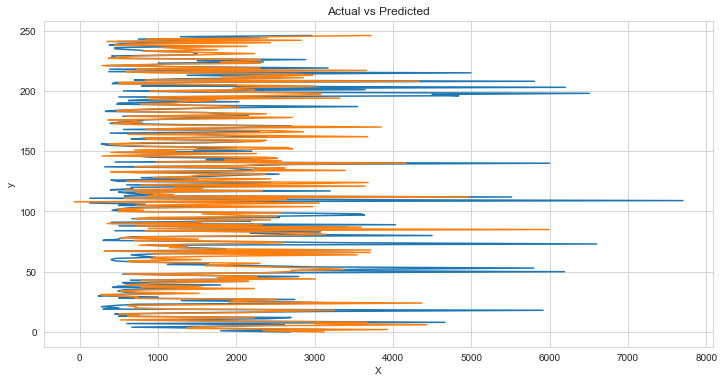

In [104]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, range(y_test.shape[0]))   
plt.plot(preds, range(y_test.shape[0])) # regression line
#plt.plot(y, y_test, 'ro')   # scatter plot showing actual data
plt.title('Actual vs Predicted')
plt.xlabel('X')
plt.ylabel('y')

plt.show()

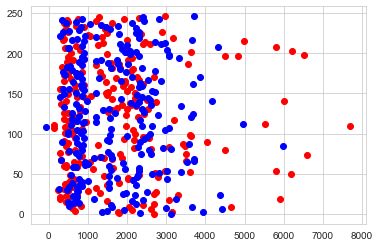

In [106]:

fig, ax = plt.subplots()

# ключ цвета из {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'}:
ax.scatter(y_test, range(y_test.shape[0]),
           c = 'r')
ax.scatter(preds, range(preds.shape[0]),
           c = 'b')

Улучшения: 
1. Учитывать другие признаки: например, бренд, так как в обычной жизни стоимость обуви и бренд сильно зависимы друг от друга. Возможно, еще что-нибудь.
2. Не использовать выбросы при обучении модели

In [107]:
rating_prediction = df[['reviews', 'reviews_rating']]

In [108]:
reviews = rating_prediction['reviews'].str.split(pat="\|\| ", expand=True).stack().reset_index(drop=True)
ratings = rating_prediction['reviews_rating'].str.split(pat="\|\| ", expand=True).stack().reset_index(drop=True)


In [109]:
rating_predict = pd.DataFrame()

In [110]:
rating_predict['reviews'] = reviews

In [111]:
rating_predict['ratings'] = ratings

In [112]:
list_stopwords = set(stopwords.words('english'))

rating_predict['clean_reviews'] = rating_predict['reviews'].str.lower()
rating_predict['clean_reviews'] = rating_predict['clean_reviews'].apply(word_tokenize)
rating_predict['clean_reviews'] = rating_predict['clean_reviews'].apply(lambda x: [word for word in x if word not in list_stopwords])
rating_predict['clean_reviews'] = rating_predict['clean_reviews'].apply(lambda x: [word.translate(str.maketrans('', '', string.punctuation)) for word in x])
rating_predict['clean_reviews'] = rating_predict['clean_reviews'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
rating_predict['clean_reviews'] = rating_predict['clean_reviews'].apply(lambda x: [word for word in x if len(word) > 1])
rating_predict['clean_reviews'] = rating_predict['clean_reviews'].apply(lambda x: [re.sub(r'[^\w\s]+|[\d]+', r'', word).strip() for word in x])
rating_predict['clean_reviews'] = rating_predict['clean_reviews'].apply(lambda x: ' '.join(x))
rating_predict['clean_reviews'] = rating_predict['clean_reviews'].apply(lambda x: str(x).replace('₹','') if '₹' in str(x) else str(x))

In [113]:
rating_predict['clean_rating'] = rating_predict['ratings'].apply(lambda x : str(x[0]))

In [114]:
rating_predict = rating_predict.drop(('reviews'), axis=1)

In [115]:
rating_predict = rating_predict.drop(('ratings'), axis=1)

In [116]:
rating_predict

,clean_reviews,clean_rating
0,happy product,1
1,expected,1
2,average product,3
3,pic beautiful,3
4,got damage product quality average,3
...,...,...
8203,go,5
8204,excellent product,5
8205,nice shoe,5
8206,nice,5


In [124]:
rating_predict.describe()

,clean_reviews,clean_rating
count,8208,8208
unique,4098,5
top,verified purchase,5
freq,429,3902


Есть дубликаты, так как уникальных занчений 4098.

In [181]:
rating_predict = rating_predict.drop_duplicates(subset=['clean_reviews'], keep=False)

In [182]:
rating_predict_2 = pd.DataFrame()
words = []
for item in rating_predict.clean_reviews.tolist():
    for element in item.split():
        words.append(element)
rating_predict_2['reviews'] = words

In [183]:
rating_predict_2

,reviews
0,pic
1,beautiful
2,got
3,damage
4,product
...,...
12050,month
12051,running
12052,asics
12053,shoe


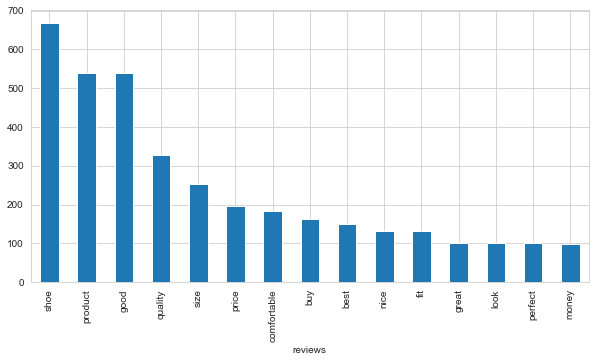

In [184]:
pd.set_option('display.max_rows',50)
rating_predict_2.groupby('reviews')['reviews'].count().sort_values(ascending=False).head(15).plot.bar(figsize=(10,5))

Посмотрим также на язык.

In [188]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0
languages_of_reviews = []
for item in rating_predict.clean_reviews:
    try:
        value = detect(item)
        languages_of_reviews.append(value)
    except:
        languages_of_reviews.append('None')


rating_predict['languages_of_reviews'] = languages_of_reviews

На самом деле, видимо этот детектор языка не совсем справляется, поэтому множество английских отзывов он определяет как неанглиские:( Тем не менее, избавимся от некоторых значений в датафрейме.

Некоторые значения оказались пустыми, поэтому мы от них избавимся.  

In [193]:
rating_predict = rating_predict.drop(rating_predict[rating_predict.languages_of_reviews == 'None'].index)

In [194]:
rating_predict['languages_of_reviews'].unique()

array(['ro', 'fr', 'en', 'tl', 'no', 'et', 'pt', 'it', 'ca', 'cy', 'nl',
       'af', 'hu', 'da', 'id', 'sq', 'sl', 'es', 'fi', 'pl', 'tr', 'sk',
       'hi', 'so', 'de', 'hr', 'mr', 'cs', 'vi', 'lt', 'sv', 'sw', 'lv',
       'ta'], dtype=object)

In [195]:
for item in rating_predict[rating_predict.languages_of_reviews != 'en'].clean_reviews:
    print(item + '\n')

pic beautiful

got damage product quality average 

buy anyway

best gym sport

must must must buy

itam received

pro con

sup quality

bang buck paisa

refund change

got one

soul shoe look like photo

thank knoos amazon

worst worst worst

get better stuff price

yah product mujhe bahut achcha

best bata range

great looking shoe like

total fake

hai bhai love

excellent sneaker

chep best

dont like thik

disastrous quality

bad quantity

junaid khan

view

budget loafer men

kinda ok specific purpose

paisa vasul product

elegance economy

qualityis bad

pasting good

must buy value money

time delivered

wrost product

buy one size le normal size

paisa wasool

bata rainy shy

buy one size small

best product price quality

excellent value money

cheap decent slipper

regular user home

extra lasting long lasting everlasting

copy original aqualite

job

ok bad ok

haa thek hi ok ok

regular use economic

rate

long lasting

user review

बहत ह खरब समन

okay hard sole

replaceme

In [196]:
rating_predict['languages_of_reviews'].unique()

array(['ro', 'fr', 'en', 'tl', 'no', 'et', 'pt', 'it', 'ca', 'cy', 'nl',
       'af', 'hu', 'da', 'id', 'sq', 'sl', 'es', 'fi', 'pl', 'tr', 'sk',
       'hi', 'so', 'de', 'hr', 'mr', 'cs', 'vi', 'lt', 'sv', 'sw', 'lv',
       'ta'], dtype=object)

Также избавимся от некоторых языков, где используются иероглифы или это правда другой язык, это: tl, et, id, hi, mr, ta (я проверила вручную). Пример ниже:

In [229]:
rating_predict[rating_predict.languages_of_reviews == 'ta']

,clean_reviews,clean_rating,languages_of_reviews
7019,படததளளத,5,ta


In [230]:
rating_predict = rating_predict.drop(rating_predict[rating_predict.languages_of_reviews == 'tl'].index)
rating_predict = rating_predict.drop(rating_predict[rating_predict.languages_of_reviews == 'et'].index)
rating_predict = rating_predict.drop(rating_predict[rating_predict.languages_of_reviews == 'id'].index)
rating_predict = rating_predict.drop(rating_predict[rating_predict.languages_of_reviews == 'hi'].index)
rating_predict = rating_predict.drop(rating_predict[rating_predict.languages_of_reviews == 'mr'].index)
rating_predict = rating_predict.drop(rating_predict[rating_predict.languages_of_reviews == 'ta'].index)

In [231]:
rating_predict

,clean_reviews,clean_rating,languages_of_reviews
3,pic beautiful,3,ro
4,got damage product quality average,3,fr
5,bad product different listed,2,en
8,low quality make pain heals sharp edge inside ...,1,en
10,memory cushioning shoe best feature,5,en
...,...,...,...
8175,mindblowing,5,pl
8178,size variation product recd size chart,5,en
8200,old manufactured product sold,3,en
8202,old stock teared month running,1,en


Посмотрим распределение по классам.

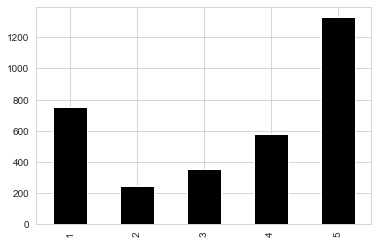

In [232]:
rating_predict['clean_rating'].value_counts().sort_index().plot.bar(color='black')

Это дисбаланс......

In [262]:
cv = CountVectorizer(max_features=1000)
X = cv.fit_transform(rating_predict.clean_reviews)
y = rating_predict.clean_rating.values

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

In [264]:
grid = {'C':np.logspace(-3,3,7), 
        'penalty':['l1', 'l2']}# l1 lasso l2 ridge

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=10)

logreg_cv.fit(X_train, y_train)

print('Best parameters: ', logreg_cv.best_params_)
print('Best score: ', logreg_cv.best_score_)

preds = logreg_cv.predict(X_test.todense())


print('MAE: ', mean_absolute_error(y_test, preds))
print('MSE: ', mean_squared_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, preds)))

Best parameters:  {'C': 0.1, 'penalty': 'l2'}
Best score:  0.5389896286383405
MAE:  1.0991432068543452
MSE:  3.1334149326805387
R2:  -0.24780450553646438
RMSE:  1.7701454552325746


In [265]:
dtm = DecisionTreeClassifier(random_state=0)

param_grid = {"max_depth": [40, 60, 80],
              "min_samples_leaf": [1, 2],
              "max_leaf_nodes": [180, 200, 220, 240],
              }

grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=5)

grid_cv_dtm.fit(X_train, y_train)
print('Best params: ', grid_cv_dtm.best_params_)
print('Best score: ', grid_cv_dtm.best_score_)

preds = grid_cv_dtm.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('MSE: ', mean_squared_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, preds)))

Best params:  {'max_depth': 80, 'max_leaf_nodes': 180, 'min_samples_leaf': 2}
Best score:  0.5185852009515463
MAE:  1.1126070991432069
MSE:  3.1052631578947367
R2:  -0.23659376193203507
RMSE:  1.7621756887140216


In [266]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()

param_grid = {"n_neighbors": [3, 5, 8],
              "algorithm": ['ball_tree', 'kd_tree', 'brute'],
              "leaf_size": [30, 40, 50],
              }

grid_cv_knc = GridSearchCV(knc, param_grid, cv=5)
grid_cv_knc.fit(X_train, y_train)

print('Best params: ', grid_cv_knc.best_params_)
print('Best score: ', grid_cv_knc.best_score_)

preds = grid_cv_knc.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('MSE: ', mean_squared_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, preds)))

Best params:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 8}
Best score:  0.4544643378823922
MAE:  1.3476132190942471
MSE:  4.037943696450428
R2:  -0.6080105717831235
RMSE:  2.00946353449134


Обучим на TFIDF.

In [267]:
tv = TfidfVectorizer(max_features=1000)
X = tv.fit_transform(rating_predict.clean_reviews)
y = rating_predict.clean_rating.values

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

In [269]:
grid = {'C':np.logspace(-3,3,7), 
        'penalty':['l1', 'l2']}# l1 lasso l2 ridge

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=10)

logreg_cv.fit(X_train, y_train)

print('Best parameters: ', logreg_cv.best_params_)
print('Best score: ', logreg_cv.best_score_)

preds = logreg_cv.predict(X_test.todense())


print('MAE: ', mean_absolute_error(y_test, preds))
print('MSE: ', mean_squared_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, preds)))

Best parameters:  {'C': 1.0, 'penalty': 'l2'}
Best score:  0.5496119103379057
MAE:  0.9596083231334149
MSE:  2.602203182374541
R2:  -0.03626264795723566
RMSE:  1.6131345828462489


In [270]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dtm = DecisionTreeClassifier(random_state=0)

param_grid = {"max_depth": [40, 60, 80],
              "min_samples_leaf": [1, 2],
              "max_leaf_nodes": [180, 200, 220, 240],
              }

grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=5)

grid_cv_dtm.fit(X_train, y_train)

print('Best params: ', grid_cv_dtm.best_params_)
print('Best score: ', grid_cv_dtm.best_score_)

preds = grid_cv_dtm.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('MSE: ', mean_squared_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, preds)))

Best params:  {'max_depth': 80, 'max_leaf_nodes': 180, 'min_samples_leaf': 1}
Best score:  0.502671007053128
MAE:  1.1334149326805385
MSE:  3.1921664626682986
R2:  -0.271200840015273
RMSE:  1.7866635001220288


In [271]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()

param_grid = {"n_neighbors": [3, 5, 8],
              "algorithm": ['ball_tree', 'kd_tree', 'brute'],
              "leaf_size": [30, 40, 50],
              }

grid_cv_knc = GridSearchCV(knc, param_grid, cv=5)
grid_cv_knc.fit(X_train, y_train)

print('Best params: ', grid_cv_knc.best_params_)
print('Best score: ', grid_cv_knc.best_score_)

preds = grid_cv_knc.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, preds))
print('MSE: ', mean_squared_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, preds)))

Best params:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 8}
Best score:  0.46835357455865784
MAE:  1.2998776009791921
MSE:  3.8384332925336597
R2:  -0.5285605192821687
RMSE:  1.9591919999156948


Лучшая модель - логистическая регрессия, обученная на TFIDF. Вывод: TFIDF > CountVectorizer - подвтреждено и моделью классификации, и моделью регрессии. 

In [272]:
grid = {'C':np.logspace(-3,3,7), 
        'penalty':['l1', 'l2']}# l1 lasso l2 ridge

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=10)

logreg_cv.fit(X_train, y_train)

print('Best parameters: ', logreg_cv.best_params_)
print('Best score: ', logreg_cv.best_score_)

preds = logreg_cv.predict(X_test.todense())


print('MAE: ', mean_absolute_error(y_test, preds))
print('MSE: ', mean_squared_error(y_test, preds))
print('R2: ', r2_score(y_test, preds))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, preds)))

Best parameters:  {'C': 1.0, 'penalty': 'l2'}
Best score:  0.5496119103379057
MAE:  0.9596083231334149
MSE:  2.602203182374541
R2:  -0.03626264795723566
RMSE:  1.6131345828462489


In [275]:
print('Accuracy: ', accuracy_score(y_test, preds)) #кошмар кошмарный

Accuracy:  0.5312117503059975


In [285]:
print('MAIN MODEL: ')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, preds)))
micro_f1 = f1_score(preds, y_test, average = 'micro')
micro_p = precision_score(preds, y_test,  average = 'micro')
micro_r = recall_score(preds, y_test,  average = 'micro')
macro_f1 = f1_score(preds, y_test, average = 'macro')
macro_p = precision_score(preds, y_test,  average = 'macro')
macro_r = recall_score(preds, y_test,  average = 'macro')
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

MAIN MODEL: 
Accuracy = 0.53121
micro F1=0.5312, micro P=0.5312, micro R=0.5312
macro F1=0.3329, macro P=0.3584, macro R=0.4055



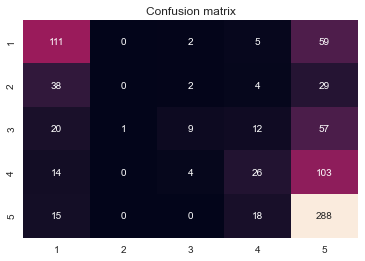

In [289]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.heatmap(data=confusion_matrix(y_test, preds), annot=True, fmt="d", cbar=False,xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title("Confusion matrix")
plt.show()

Множество элементов распознались как 1 или 5 по той причине, что классы несбалансированы. Из этого следует, что для улучшения модели нужно в первую очередь их сбалансировать.